In [1]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dropout
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import re
import string
import pandas as pd

In [2]:
# import dataset
df = pd.read_csv("dataset.csv")
df.head()

,Emotion,Text
0,neutral,@dannycastillo Houston ticket neitu nen kan in...
1,neutral,cant fall muhil thei lo
2,neutral,Balisage Markup Conference 2009 Program-a No T...
3,neutral,@cynthia_123 i muhil thei lo
4,neutral,Bus bl***y chu ka miss ta!!!!!!!!


In [3]:
#shuffle the dataset
df = df.sample(frac = 1)

In [4]:
# text processing function 
def clean_text(text):
    # to lower case
    text = text.lower()
    # remove links
    text = re.sub('https:\/\/\S+', '', text) 
    # remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) 
    # remove next line     
    text = re.sub(r'[^ \w\.]', '', text) 
    # remove words containing numbers
    text = re.sub('\w*\d\w*', '', text)
    
    return text
# Create a new column called "Text" for collecting clean text
df['Text'] = df.Text.apply(lambda x: clean_text(x))

In [5]:
# Stop word in  mizo language
stop_words  = "a, i si a min em  le tak te e in he u tih ka va keimah keini kan keimahni nangmah nangma nangmahni ngei pawh ani amah a ta chu ni chumi anni an engnge khawi tunge hei sawmi hengte hi tawh nei ti mek leh mahse chuan emaw avang angin hma laiin tan hmunah tu nen lam kalh karah chhungah tlang hmaah hnuah chungah hnuai ah atangin chunglam hnuailam chhung pawn titawp hla zawk tichuan vawikhat hetah sawtah engtikah khawnge engati nge engtin zavai engpawh pahnihin vek tlem belh ber thildang engemawzat chutiang aih ve chauh inang chuvangin aiin lutuk thei duhdan chiah don tur tunah"

# Convert to lower case
stop_words = stop_words.lower()

# convert string to list
def Convert(string):
    li = list(string.split(" "))
    return li


stop_word_list = Convert(stop_words)

# Remove stop words
df['Text'] = df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_word_list)]))

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Define the labels
labels = df["Emotion"].apply(lambda x: x.split(','))

# Binarize the labels
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(labels)

# The hyperparameters required to tune the network.
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"

# Tokenize and pad the sequences
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(df["Text"])
sequences = tokenizer.texts_to_sequences(df["Text"])
padded_sequences = pad_sequences(sequences,maxlen=max_length,truncating=trunc_type)
max_length = padded_sequences.shape[1]

# Compute the count vectorization features for the padded sequences
cv = CountVectorizer()
cv_matrix = cv.fit_transform([' '.join([str(word) for word in sequence]) for sequence in padded_sequences])
cv_matrix_dense = cv_matrix.toarray()

# Reshape the cv_matrix_dense to a 3D tensor
cv_matrix_3d = cv_matrix_dense.reshape((cv_matrix_dense.shape[0], 1, cv_matrix_dense.shape[1]))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(cv_matrix_3d, y, test_size=0.2, random_state=42)

# Define the LSTM model architecture
model = Sequential()
model.add(LSTM(units=64, input_shape=(cv_matrix_3d.shape[1], cv_matrix_3d.shape[2]), dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(units=32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=y.shape[1], activation='softmax'))

# Compile and train the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))



Epoch 1/10
299/299 [==============================] - 38s 102ms/step - loss: 1.4437 - accuracy: 0.3836 - val_loss: 1.2692 - val_accuracy: 0.4822
Epoch 2/10
299/299 [==============================] - 30s 99ms/step - loss: 1.0819 - accuracy: 0.5837 - val_loss: 0.9810 - val_accuracy: 0.6507
Epoch 3/10
299/299 [==============================] - 30s 100ms/step - loss: 0.7578 - accuracy: 0.7332 - val_loss: 0.8969 - val_accuracy: 0.6855
Epoch 4/10
299/299 [==============================] - 31s 105ms/step - loss: 0.5994 - accuracy: 0.7880 - val_loss: 0.9067 - val_accuracy: 0.6969
Epoch 5/10
299/299 [==============================] - 31s 104ms/step - loss: 0.5080 - accuracy: 0.8222 - val_loss: 0.9348 - val_accuracy: 0.6964
Epoch 6/10
299/299 [==============================] - 31s 102ms/step - loss: 0.4707 - accuracy: 0.8350 - val_loss: 0.9494 - val_accuracy: 0.6969
Epoch 7/10
299/299 [==============================] - 30s 99ms/step - loss: 0.4335 - accuracy: 0.8485 - val_loss: 0.9584 - val_accu

In [19]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

68/68 [==============================] - 1s 14ms/step - loss: 1.0510 - accuracy: 0.6988
Test loss: 1.0509588718414307
Test accuracy: 0.6988344788551331


In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the predicted and actual labels
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 score: {f1}")

68/68 [==============================] - 2s 14ms/step
Accuracy: 0.6988344988344989
Precision: 0.6979224175408144
Recall: 0.6988344988344989
F1 score: 0.6975393933105097


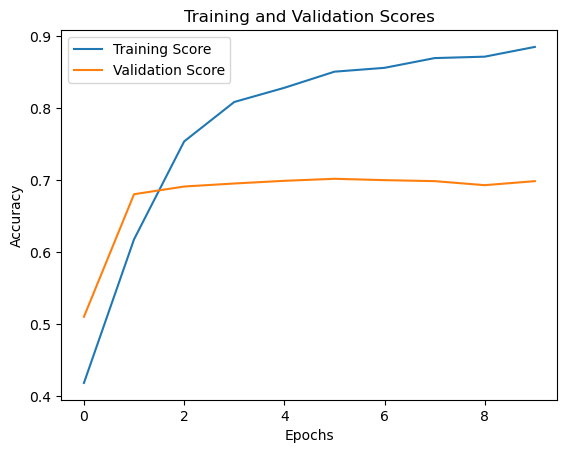

In [21]:
import matplotlib.pyplot as plt

# Get the training and validation scores from the history object returned by the fit() method
train_scores = history.history['accuracy']
val_scores = history.history['val_accuracy']

# Plot the training and validation scores on a line graph
plt.plot(train_scores, label='Training Score')
plt.plot(val_scores, label='Validation Score')
plt.title('Training and Validation Scores')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [6]:
import numpy as np

# Create a pipeline for predicting using new text
def predict_emotion(text):
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_length,truncating=trunc_type)
    cv_sequence = cv.transform([' '.join([str(word) for word in sequence]) for sequence in padded_sequence])
    cv_sequence_dense = cv_sequence.toarray()
    cv_sequence_3d = cv_sequence_dense.reshape((cv_sequence_dense.shape[0], 1, cv_sequence_dense.shape[1]))
    predictions = model.predict(cv_sequence_3d)
    predicted_labels_binary = np.zeros_like(predictions)
    predicted_labels_binary[np.arange(len(predictions)), predictions.argmax(1)] = 1
    predicted_labels = mlb.inverse_transform(predicted_labels_binary)[0]
    return predicted_labels

# Test the pipeline
text = "ka thinrim"
predicted_labels = predict_emotion(text)
print(predicted_labels)


1/1 [==============================] - 1s 505ms/step
('anger',)


In [11]:
word_index = tokenizer.word_index

In [ ]:
# one of the preprocessed sentence.
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
print(decode_review(padded_sequences[2]))

In [ ]:
df.head()

In [7]:
# Independent variables (no target column)
Xfeatures = df["Text"]
# Targets
ylabels = df["Emotion"]

In [12]:
# Tokenize the text data using CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(Xfeatures)
tokenized_data = vectorizer.transform(Xfeatures)

In [14]:
# Reshape the count vectors into a 3D numpy array
reshaped_data = np.reshape(tokenized_data.toarray(), (len(Xfeatures), tokenized_data.shape[1], 1))

In [15]:
model = Sequential()
model.add(LSTM(64, input_shape=(tokenized_data.shape[1], 1),dropout=0.2, recurrent_dropout=0.2, return_sequences=True ))
model.add(LSTM(units=32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=y.shape[1], activation='softmax'))

In [16]:
# Define the labels
labels = df["Emotion"].apply(lambda x: x.split(','))

# Binarize the labels
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(labels)
